# Rucio transfer errors

This notebook contains an attempt of data exploration for Rucio transfer errors.

### Imports
Import libraries and write settings here.

In [1]:
# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

## General packages 

In [2]:
# Data manipulation
import pandas as pd
import numpy as np
import json

# Visualizations
import seaborn as sns
from matplotlib import pyplot as plt

# Options for pandas
pd.options.display.max_columns = 50
pd.options.display.max_rows = 30
pd.options.display.float_format = '{:,.4f}'.format

## Custom imports
None at the moment

# Data Exploration 

## Reading data 

In [3]:
!pwd

/home/luca/workspace/rucio-log-clustering/notebooks


Read data fetched from Rucio API: http://rucio-opint.web.cern.ch/api/issues/

In [4]:
%%time

# read data downloaded through ../code/fetch_data.py
with open("../issues.json", 'r') as f:
    raw_data = json.load(f)

# reorganise them in a pandas dataframe structure    
errors = pd.DataFrame()
for page in raw_data:
    for record in page:
        idx = record.pop('id')
        temp = pd.DataFrame(record, index=[idx])
        errors = errors.append(temp)
        #break
#     break


print("Dataframe dimensions:", errors.shape)

Dataframe dimensions: (2826, 8)
CPU times: user 5.6 s, sys: 17.4 ms, total: 5.62 s
Wall time: 5.62 s


In [5]:
errors.head()

,message,src_site,dst_site,category,amount,type,status,last_modified
1,SOURCE [70] globus_xio: Unable to connect to a...,BU_ATLAS_Tier2,BNL-ATLAS,9,178,transfer-failure,New,2019-08-06T14:07:04.412401+02:00
2,TRANSFER [70] TRANSFER globus_xio: Unable to ...,BNL-ATLAS,BU_ATLAS_Tier2,10,3288,transfer-failure,New,2019-08-06T14:07:04.595574+02:00
3,TRANSFER [70] TRANSFER globus_xio: Unable to ...,INFN-NAPOLI-ATLAS,BU_ATLAS_Tier2,10,3288,transfer-failure,New,2019-08-06T14:07:04.692554+02:00
4,SOURCE [70] globus_xio: Unable to connect to a...,BU_ATLAS_Tier2,CERN-PROD,11,227,transfer-failure,New,2019-08-06T14:07:04.803866+02:00
5,SOURCE [70] globus_xio: Unable to connect to a...,BU_ATLAS_Tier2,TOKYO-LCG2,11,130,transfer-failure,New,2019-08-06T14:07:04.891438+02:00


In [6]:
errors.dtypes

message          object
src_site         object
dst_site         object
category          int64
amount            int64
type             object
status           object
last_modified    object
dtype: object

*Category* is interpreted as an int61, however this has to be dealt with as an object, so we tranform it:

In [7]:
errors = errors.astype({'category': 'object'})
errors.dtypes

message          object
src_site         object
dst_site         object
category         object
amount            int64
type             object
status           object
last_modified    object
dtype: object

Get a brief description of feature values:

## Descriptive statistics 

In [8]:
table_sumary = errors.describe(include=['object', 'category', 'int64'])
table_sumary
# errors.describe(include=['category'])

,message,src_site,dst_site,category,amount,type,status,last_modified
count,2826,2826,2826,"2,826.0000","2,826.0000",2826,2826,2826
unique,589,90,92,340.0000,nan,2,1,2726
top,Transfer has been forced-killed because it was...,BNL-ATLAS,UKI-SCOTGRID-DURHAM,128.0000,nan,transfer-failure,New,2019-08-07T15:00:06.690422+02:00
freq,67,192,308,302.0000,nan,2684,2826,2
mean,NaN,NaN,NaN,nan,"2,198.5191",NaN,NaN,NaN
std,NaN,NaN,NaN,nan,"5,690.2502",NaN,NaN,NaN
min,NaN,NaN,NaN,nan,1.0000,NaN,NaN,NaN
25%,NaN,NaN,NaN,nan,120.2500,NaN,NaN,NaN
50%,NaN,NaN,NaN,nan,555.5000,NaN,NaN,NaN
75%,NaN,NaN,NaN,nan,"1,537.0000",NaN,NaN,NaN


First thing we can notice is that we have 2826 records, but only 589 unique messages.

As far as sites, we have almost a perfect balance in the repartition between source sites (90) and destination sites (92).

Let now explore the most common values for the 3 features mentioned above:

In [12]:
for feature_name in ['message', 'src_site', 'dst_site']:
    print(feature_name, "\n", table_sumary.loc["top"][feature_name], "\nFrequency\n", 
          table_sumary.loc["freq"][feature_name], "\n")

message 
 Transfer has been forced-killed because it was stalled 
Frequency
 67 

src_site 
 BNL-ATLAS 
Frequency
 192 

dst_site 
 UKI-SCOTGRID-DURHAM 
Frequency
 308 



## Null values
Let now investigate the structure of missing values:

In [13]:
errors[errors.isnull().any(axis=1)]

,message,src_site,dst_site,category,amount,type,status,last_modified


There seem to be no missing values are present in any variable. However, it may be we have NAs coded with non-standard patterns (e.g. src/dst site == UNKNOWN).

<div class="alert alert-block alert-info">
<b>Tip:</b> In case we need to fill NAs:
    
`errors = errors.fillna({"VAR_NAME": <FILL_VALUE>})`

In order to choose how to impute missing values, a simple strategy may be to look at the most common value:

`errrors.<VAR_NAME>.value_counts()`
</div>

## Errors distribution per src/dst site 

In [14]:
print("Source site distribution:\n", errors["src_site"].value_counts())
print("\nDestination site distribution:\n", errors["dst_site"].value_counts())

Source site distribution:
 BNL-ATLAS             192
INFN-T1               190
UNKNOWN               147
CERN-PROD             133
CSCS-LCG2             121
                     ... 
FR-ALPES                1
IL-TAU-HEP              1
UKI-SOUTHGRID-SUSX      1
INFN-LECCE              1
INFN-ROMA2              1
Name: src_site, Length: 90, dtype: int64

Destination site distribution:
 UKI-SCOTGRID-DURHAM       308
CSCS-LCG2                 306
UNKNOWN                   266
DESY-HH                   105
CERN-PROD                 102
                         ... 
UKI-LT2-Brunel              1
FR-ALPES                    1
CA-TRIUMF-DISKLESS          1
INFN-GENOVA                 1
UKI-SOUTHGRID-BHAM-HEP      1
Name: dst_site, Length: 92, dtype: int64


Probably the the bigger/most problematic sites explain alone great part of the errors. 

Let's check this assumption by computing the percentage of total error detained from the top N (say 12) src/dst sites:

In [20]:
top_n = 12

print("Source sites:")
np.sum(errors.src_site.value_counts()[:top_n] / np.sum(errors.src_site.value_counts()) )
print("\nDestination sites:")
np.sum(errors.dst_site.value_counts()[:top_n] / np.sum(errors.dst_site.value_counts()) )

Source sites:


0.45470629865534323


Destination sites:


0.5548478414720452

So the top ~10% of sites collect nearly 50% of the total transfer errors in the dataset.

Let see what are the problemati sites in more details:

In [22]:
top_lbl_src = errors.src_site.value_counts().index.tolist()[:top_n]
top_lbl_dst = errors.dst_site.value_counts().index.tolist()[:top_n]

In [25]:
print("Top", top_n, "source sites:\n", top_lbl_src)
print("\nTop", top_n, "destination sites:\n", top_lbl_dst)

Top 12 source sites:
 ['BNL-ATLAS', 'INFN-T1', 'UNKNOWN', 'CERN-PROD', 'CSCS-LCG2', 'FZK-LCG2', 'IN2P3-CC', 'RAL-LCG2', 'NIKHEF-ELPROD', 'DESY-HH', 'UKI-SCOTGRID-GLASGOW', 'TRIUMF-LCG2']

Top 12 destination sites:
 ['UKI-SCOTGRID-DURHAM', 'CSCS-LCG2', 'UNKNOWN', 'DESY-HH', 'CERN-PROD', 'RAL-LCG2', 'FZK-LCG2', 'BU_ATLAS_Tier2', 'Taiwan-LCG2', 'BNL-ATLAS', 'UKI-LT2-QMUL', 'MWT2']


### Bivariate distribution: src site $\times$ dst site  

In [27]:
# retrieve only rows having src/dst site in the top_n list
errors_top_sites = errors.query("src_site in @top_lbl_src and dst_site in @top_lbl_dst")
errors_top_sites.head()

,message,src_site,dst_site,category,amount,type,status,last_modified
2,TRANSFER [70] TRANSFER globus_xio: Unable to ...,BNL-ATLAS,BU_ATLAS_Tier2,10,3288,transfer-failure,New,2019-08-06T14:07:04.595574+02:00
13,SOURCE [70] srm-ifce err: Communication error ...,INFN-T1,RAL-LCG2,19,693,transfer-failure,New,2019-08-23T10:00:07.897494+02:00
16,The requested service is not available at the ...,UNKNOWN,UKI-SCOTGRID-DURHAM,22,2775,deletion-failure,New,2019-08-07T11:00:07.300014+02:00
17,Failed to stage-out logs to OS: no OS_LOGS ddm...,IN2P3-CC,UNKNOWN,23,1,transfer-failure,New,2019-08-07T19:00:04.747496+02:00
21,Could not figure out destination path from dst...,IN2P3-CC,UNKNOWN,24,2,transfer-failure,New,2019-09-18T23:00:09.645147+02:00


Let now plot to see whether we can catch some src/dst correlation:

CPU times: user 322 ms, sys: 125 ms, total: 447 ms
Wall time: 201 ms


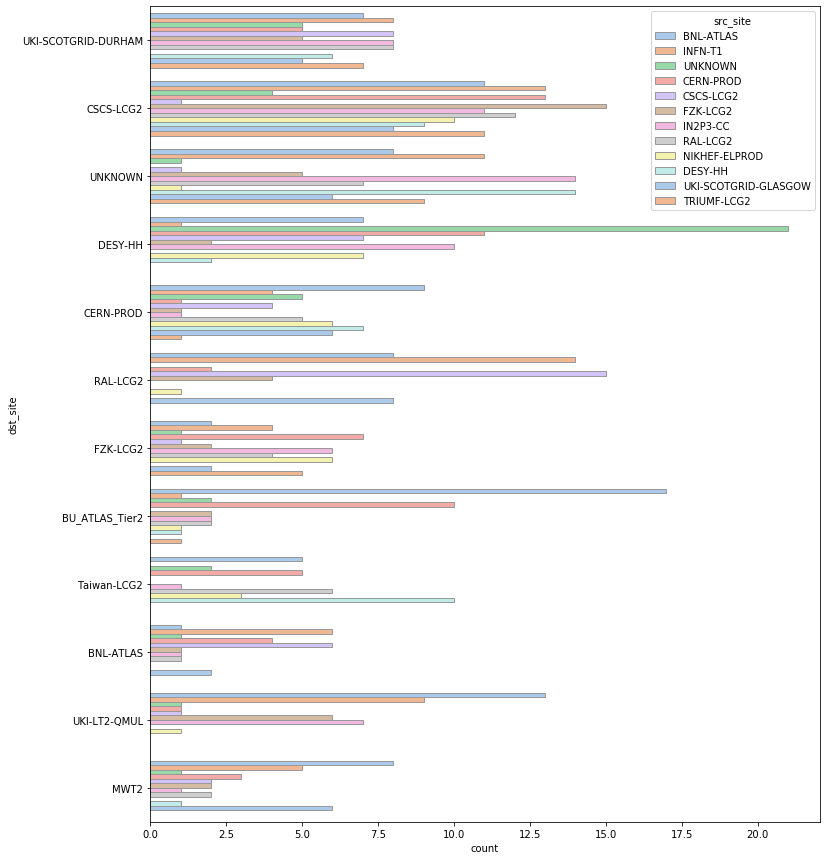

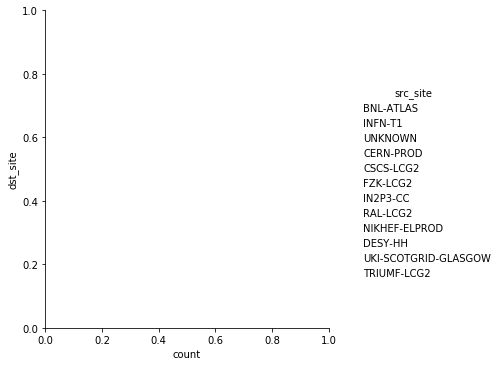

In [42]:
%%time

# val = "deletion-failure"

f, ax = plt.subplots(figsize=(12, 15))
sns.catplot(ax=ax, y="dst_site", hue="src_site", kind="count",
            palette="pastel", edgecolor=".6", order = top_lbl_dst, hue_order=top_lbl_src,
            data=errors_top_sites) #if we want to filter: errors_top_sites.query("type==@val "))

Given the large number of sites it is very difficult to extract meaningful information from the plot above.

One thing one can notice is that **BNL-ATLAS** is among the top source sites for almost any destination site, so it seems to have problem to reach/get conctacted irrespectively from the destination endpoint.

On the other hand, the next thing that leaps to the eye is the great amount of errors where the destination is **DESY-HH** and the source is **UNKNOWN**.

### Additional  bivariate distribution
A more quantitative view of the src $\times$ dst sites bivariate distribution is presented in the following.

In [43]:
grouped = errors_top_sites.groupby(["src_site", "dst_site"])
grouped.size()

src_site   dst_site           
BNL-ATLAS  BNL-ATLAS               1
           BU_ATLAS_Tier2         17
           CERN-PROD               9
           CSCS-LCG2              11
           DESY-HH                 7
                                  ..
UNKNOWN    MWT2                    1
           Taiwan-LCG2             2
           UKI-LT2-QMUL            1
           UKI-SCOTGRID-DURHAM     5
           UNKNOWN                 1
Length: 117, dtype: int64

In [46]:
bivar_sites = pd.crosstab(index=errors_top_sites["src_site"], 
                          columns=errors_top_sites["dst_site"])

bivar_sites

dst_site,BNL-ATLAS,BU_ATLAS_Tier2,CERN-PROD,CSCS-LCG2,DESY-HH,FZK-LCG2,MWT2,RAL-LCG2,Taiwan-LCG2,UKI-LT2-QMUL,UKI-SCOTGRID-DURHAM,UNKNOWN
src_site,,,,,,,,,,,,
BNL-ATLAS,1,17,9,11,7,2,8,8,5,13,7,8
CERN-PROD,4,10,1,13,11,7,3,2,5,1,5,0
CSCS-LCG2,6,0,4,1,7,1,2,15,0,1,8,1
DESY-HH,0,1,7,9,2,0,1,0,10,0,6,14
FZK-LCG2,1,2,1,15,2,2,2,4,0,6,5,5
IN2P3-CC,1,2,1,11,10,6,1,0,1,7,8,14
INFN-T1,6,1,4,13,1,4,5,14,0,9,8,11
NIKHEF-ELPROD,0,1,6,10,7,6,0,1,3,1,0,1
RAL-LCG2,1,2,5,12,0,4,2,0,6,0,8,7


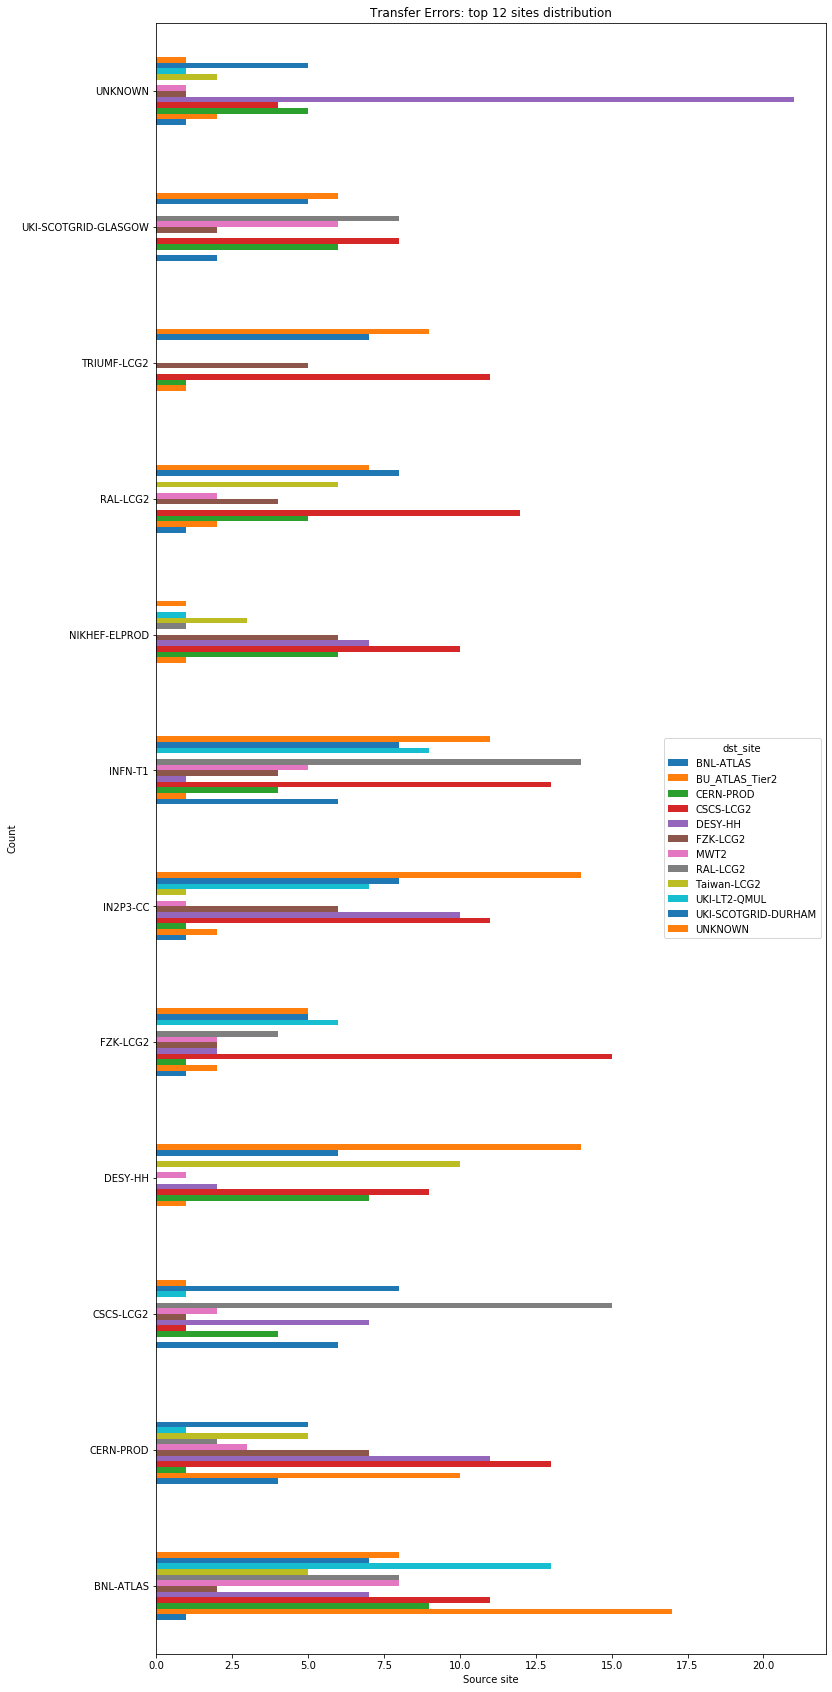

In [47]:
brplt = bivar_sites.plot(kind="barh", 
                 figsize=(12,30),
                 stacked=False, title="Transfer Errors: top 12 sites distribution", sort_columns=True)
_ = plt.xlabel("Source site")
_ = plt.ylabel("Count")

# Analysis/Modeling
Do work here

# Results
Show graphs and stats here

# Conclusions and Next Steps
Summarize findings here